# Small-world networks

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

The *small-world phenomenon* is, broadly speaking, the observation that any two people in a group can be connected by a surprisingly short path of acquaintances. This concept appears in the "Bacon number" game, where actors are nodes, appearing in the same movie creates an edge between them, and one tries to find the distance between Kevin Bacon and some other designated actor. 

In network science, there are two type of measurements used to quantify the effect: distance and clustering.

## Distance

The **distance** between two nodes in a connected graph is the number of edges in the shortest path between them. In a complete graph, the distance between any pair of distinct nodes is 1, since all possible pairs are connected by an edge.

In [2]:
K5 = nx.complete_graph(5)
dist = [ nx.shortest_path_length(K5,0,i) for i in K5.nodes ]
print("Distance from node 0:",dist)

Distance from node 0: [0, 1, 1, 1, 1]


The maximum distance over all pairs of nodes in a graph is called its **diameter**. Since this value depends on an extreme outlier in the degree distribution, it is often preferred to use the **average distance** as a measure of how difficult it is to connect two randomly selected nodes.

For example, here is a *wheel graph*:

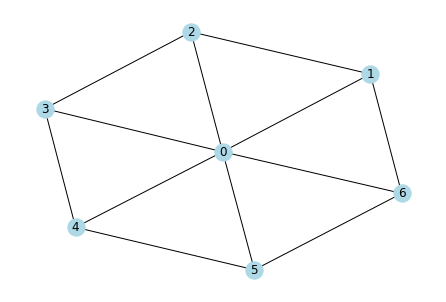

In [3]:
W = nx.wheel_graph(7)
nx.draw(W,with_labels=True,node_color="lightblue")

No node is more than two hops away from another, if the first hop is to node 0, so the diameter of this graph is 2. The average distance is somewhat smaller. This graph is so small that we can easily find the entire matrix of pairwise distances.

In [4]:
D = np.array([ [nx.shortest_path_length(W,i,j) for j in range(7)] for i in range(7) ])
print(D)

[[0 1 1 1 1 1 1]
 [1 0 1 2 2 2 1]
 [1 1 0 1 2 2 2]
 [1 2 1 0 1 2 2]
 [1 2 2 1 0 1 2]
 [1 2 2 2 1 0 1]
 [1 1 2 2 2 1 0]]


Only the entries in the upper triangle need to be averaged. However, by the symmetry, we can sum over all the entries and divide by $2\binom{n}{2}$:

In [5]:
print("average distance:",D.sum()/(7*6))

average distance: 1.4285714285714286


## Clustering

Intuitively, the idea behind clustering is that your friends tend to be friends of one another. There are various ways to quantify this precisely, but the easiest is the **local clustering coefficient**, defined for a node $i$ as

$$
C_i = \frac{ 2 T_i }{k_i(k_i-1)}.
$$

In this formula, $k_i$ is the degree of the node and $T_i$ is the number of edges between node $i$'s neighbors. Equivalently, $T_i$ is the number of triangles in the graph that pass through node $i$. Because the subgraph of the friend nodes has

$$
\binom{k_i}{2}
$$

possible edges, the maximum of $C_i$ is 1.

For example, let's continue with the wheel graph above.

Node 0 in this graph is adjacent to 6 other nodes, and there are 6 triangles passing through it. Thus, its clustering coefficient is

$$
C_0 = \frac{6}{6 \cdot 5 / 2} = \frac{2}{5}.
$$

In [6]:
nx.clustering(W,0)

0.4

Every other node has 3 friends and 2 triangles, so they each have

$$
C = \frac{2}{3 \cdot 2 / 2} = \frac{2}{3}.
$$

In [7]:
nx.clustering(W,1)

0.6666666666666666

## ER graphs

Let's look at distance and clustering within ER random graphs. We quickly run into a problem: the ER graph may not have a path between all pairs of points. We say that such a graph is not **connected**.

In [8]:
n,p = 101,1/25
ER = nx.erdos_renyi_graph(n,p,seed=0)
nx.is_connected(ER)

False

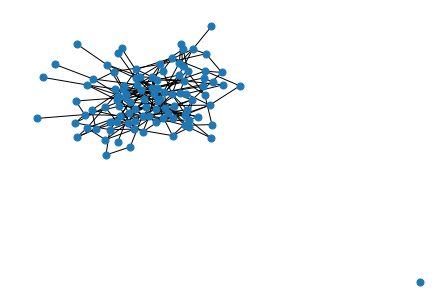

In [9]:
nx.draw(ER,node_size=50)

The most sensible definition of distance to the lone node is infinity, and averages including infinity are themselves infinite. We have the same problem when it comes to clustering, since the degree of the isolated node is zero. 

At this point, let's ask how often this happens. For  $n=251$, $p=1/50$, the expected $\bar{k}$ is $5$.

In [10]:
n,p = 251,1/50
is_connected = sum( nx.is_connected(nx.erdos_renyi_graph(n,p,seed=iter+1)) for iter in range(500) )
print(f"{is_connected/500:.1%} are connected")

19.2% are connected


Let's crank up the expected $\bar{k}$ to 10.

In [11]:
n,p = 251,1/25
is_connected = sum( nx.is_connected(nx.erdos_renyi_graph(n,p,seed=iter+10)) for iter in range(1000) )
print(f"{is_connected/500:.1%} are connected")

198.0% are connected


Let's cut a little slack at this point and look at what the distance and clustering are for those ER graphs which are connected.

average distances:


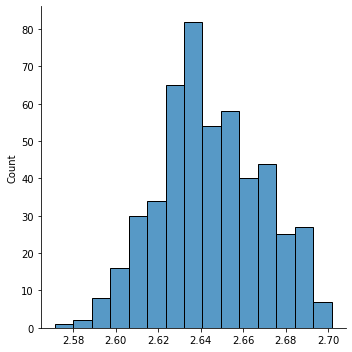

In [12]:
n,p = 251,1/25
dbar,cbar = [],[]
for iter in range(500):
    ER = nx.erdos_renyi_graph(n,p,seed=iter+5)
    if nx.is_connected(ER):
        dbar.append(nx.average_shortest_path_length(ER))
        cbar.append(nx.average_clustering(ER))        

print("average distances:")
sns.displot(x=dbar,bins=15);

average clustering:


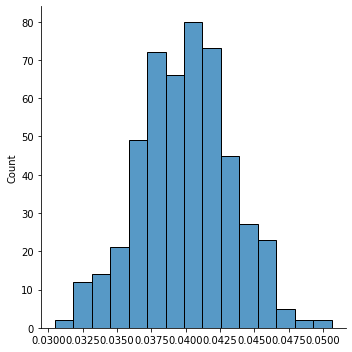

In [13]:
print("average clustering:")
sns.displot(x=cbar,bins=15);

Hence, when the graph is connected, the local clustering is close to zero; there is no special affinity for friendship among one's friends.

## Twitch network

Let's consider the Twitch network again.

In [14]:
twitch = nx.read_edgelist("musae_edges.csv",delimiter=',',nodetype=int)
n,E = twitch.number_of_nodes(),twitch.number_of_edges()
kbar = 2*E/n
print(n,"nodes and",E,"edges")
print(f"average degree is {kbar:.3f}")

7126 nodes and 35324 edges
average degree is 9.914


This graph is far from complete: the average degree of 9.9 is a far cry from 7,125. Computing the distances between all pairs of nodes in this graph would take a rather long time, so we will estimate the average distance by sampling.

In [15]:
from numpy.random import default_rng
rng = default_rng(1)

# Compute the distance between a random pair of distinct nodes:
def pairdist(G):
    n = nx.number_of_nodes(G)
    i = j = rng.integers(0,n)
    while i==j: j=rng.integers(0,n)   # get distinct nodes
    return nx.shortest_path_length(G,source=i,target=j)

distances = pd.Series([pairdist(twitch) for _ in range(100000)])

print("For Twitch graph...")
print("Distribution of distance samples:")
print(distances.value_counts())
print("\nEstimated mean distance:",distances.mean())

For Twitch graph...
Distribution of distance samples:
4    42813
3    36231
5    12570
2     6294
6     1724
7      191
1      159
8       17
9        1
dtype: int64

Estimated mean distance: 3.67368


This may seem surprisingly small. More on that in a moment. First, let's also look at the clustering coefficients:

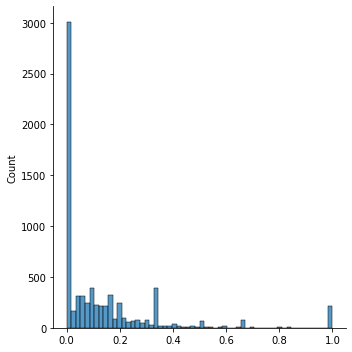

In [16]:
cluster_coeffs = pd.Series([ nx.clustering(twitch,i) for i in twitch.nodes ])
sns.displot(x=cluster_coeffs);

The distribution above casts some doubt about using the mean as a summary, but for the record, the value is

In [17]:
cluster_coeffs.mean()

0.13092821901472096

Let's compare these results to ER graphs with the same size and average degree. It's time-consuming to sample enough graphs to be statistically meaningful, so we do just a few here to get a taste.

In [18]:
p = kbar/(n-1)

dbar = []
cbar = []
for iter in range(4):
    ER = nx.erdos_renyi_graph(n,p,seed=iter)
    if nx.is_connected(ER):
        dist = [pairdist(ER) for _ in range(100)]
        dbar.append(np.mean(dist))
        cbar.append(nx.average_clustering(ER))        

print("For ER graphs:")
print("Average of mean distance:",np.mean(dbar))
print("Average of mean clustering:",np.mean(cbar))

For ER graphs:
Average of mean distance: 4.14
Average of mean clustering: 0.001434606204988957


In fact, theory states that the mean distance in ER graphs is expected to be approximately 

$$
\frac{\ln(n)}{\ln(\bar{k})}
$$

as $n\to\infty$.

In [19]:
np.log(n)/np.log(kbar)

3.8673326382368893

Either way, the average distance in an ER graph is not so different from the Twitch network. However, ER graphs show essentially no local clustering, unlike the Twitch network. In fact, since all edges in an ER graph appear with probability $p$, then we expect the local clustering to be $p=\bar{k}/(n-1)$ as well.

In [20]:
p

0.0013914550620165345

It's reasonable to conclude that this social network has greater likelihood of "my friends are also friends of each other" than a random ER graph has.

## Watts–Strogatz graphs

A **Watts–Strogatz graph** (WS graph) tries to model the small-world phenomenon. A WS graph has three parameters: $n$, an even integer $k$, and a probability $q$. 

Imagine $n$ nodes arranged in a circle. Connect each node with an edge to each of its $k/2$ left neighbors and $k/2$ right neighbors. Now visit each node $i$ in turn. For each edge from $i$ to a neighbor, with probability $q$ replace it with an edge between $i$ and a node chosen at random from all the nodes $i$ is not currently connected to. The idea is to start with tight-knit, overlapping communities, and randomly toss in some far-flung links.

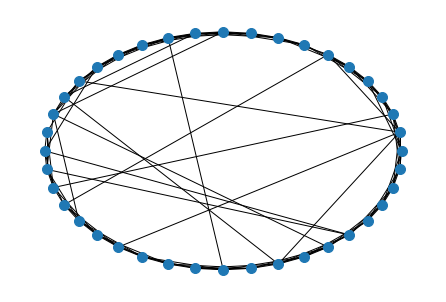

In [21]:
WS = nx.watts_strogatz_graph(40,6,0.15,seed=1)
nx.draw_circular(WS,node_size=100)

For $q<1$, a WS graph has a mean clustering coefficient that is significantly above zero.

In [22]:
n,k = 60,6
results = pd.DataFrame({"q":[],"mean cluster":[]})
seed = 0
for q in np.arange(0.05,1.05,0.05):
    cbar = []
    for iter in range(50):
        WS = nx.watts_strogatz_graph(n,k,q,seed=seed)
        cbar.append(nx.average_clustering(WS))
        seed += 1
    results = pd.concat((results,
                         pd.DataFrame({"q":q,"mean cluster":cbar})),
                        ignore_index=True)

Mean clustering in WS graphs on 60 nodes:


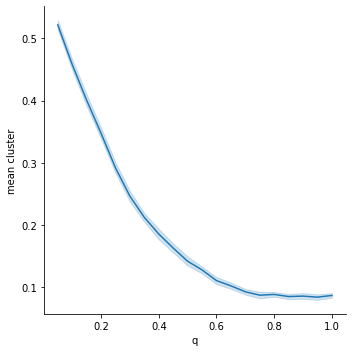

In [23]:
print("Mean clustering in WS graphs on 60 nodes:")
sns.relplot(data=results,x="q",y="mean cluster",kind="line");

Let's scale the experiment up to the size of the Twitch network.

In [24]:
results = pd.DataFrame({"q":[],"mean cluster":[]})
seed = 0
n,k = twitch.number_of_nodes(),10
for q in np.arange(0.05,1,0.1):
    cbar = []
    for iter in range(6):
        WS = nx.watts_strogatz_graph(n,k,q,seed=seed)
        cbar.append(nx.average_clustering(WS))
        seed += 1
    results = pd.concat((results,
                         pd.DataFrame({"q":q,"mean cluster":cbar})),
                        ignore_index=True)

Mean clustering in WS graphs on 7126 nodes:


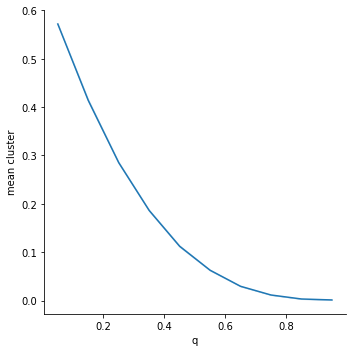

In [25]:
print("Mean clustering in WS graphs on",n,"nodes:")
sns.relplot(data=results,x="q",y="mean cluster",kind="line");

The mean clustering resembles the value of 0.13 for the Twitch network at around $q=0.4$. However, that leaves the mean distance a bit too large:

In [26]:
results = pd.DataFrame({"q":[],"mean distance":[]})
seed = 0
n,k,q = twitch.number_of_nodes(),10,0.4
for iter in range(30):
    WS = nx.watts_strogatz_graph(n,k,q,seed=seed)
    d = sum(pairdist(WS) for _ in range(100))
    dbar.append(d/100)
    seed += 1
print("mean distance in WS:",np.mean(dbar))

mean distance in WS: 4.44774193548387


At this point it's inconclusive whether the WS construction can explain the Twitch network. In the next section, we will see that it is lacking in an important way.